<a href="https://colab.research.google.com/github/MartinBruchon/MartinBruchon/blob/main/corrosion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *
from lxml import etree
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
!unzip -q dataset.zip

In [3]:
def dirparser(path):
    path = Path(path)
    output = []
    for folders in os.listdir(path):
        for fname in os.listdir(path / folders):
            _, ext = fname.split('.')
            if ext in ['png', 'PNG', 'jpg', 'JPG', 'jpeg', 'JPEG']:
                img = Image.open(path / folders / fname).convert('RGB')
                output.append((np.array(img), folders))
    return output

In [4]:
train_set = dirparser("./images/train")
valid_set = dirparser("./images/valid")

(<matplotlib.image.AxesImage at 0x7fc6bbb92080>, 'NOK')

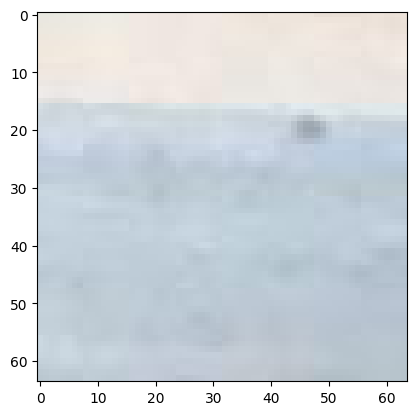

In [6]:
x, y = valid_set[1]
plt.imshow(x), y

In [7]:
val_idx = list(range(len(train_set), len(train_set) + len(valid_set)))

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x = ItemGetter(0),
                   get_y = ItemGetter(1),
                   splitter=IndexSplitter(val_idx),
                   item_tfms=[Resize(64, method='squish')],
                   batch_tfms=[*aug_transforms(size=64, 
                                               max_rotate=90, 
                                               max_zoom=2,
                                               max_lighting=0.25), 
                               Normalize.from_stats(*imagenet_stats)])               


dls = dblock.dataloaders(train_set + valid_set, bs=8, shuffle_train=True)

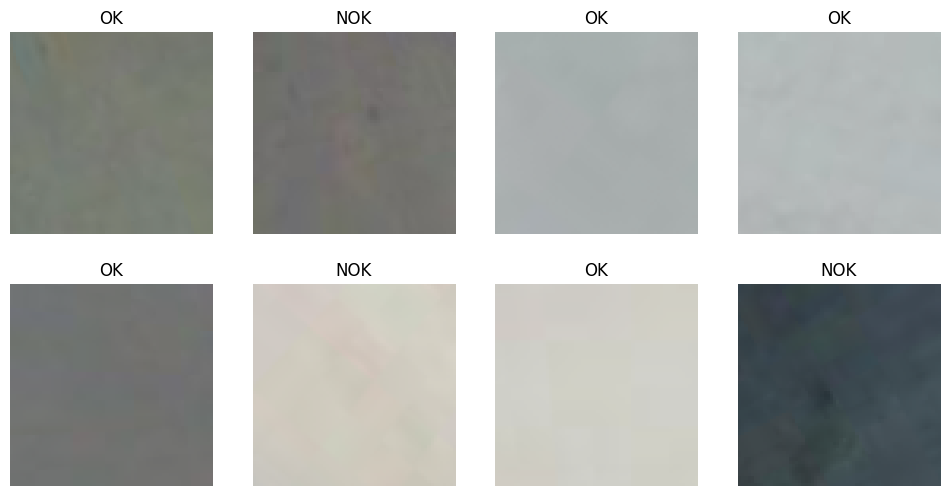

In [8]:
dls.train.show_batch()

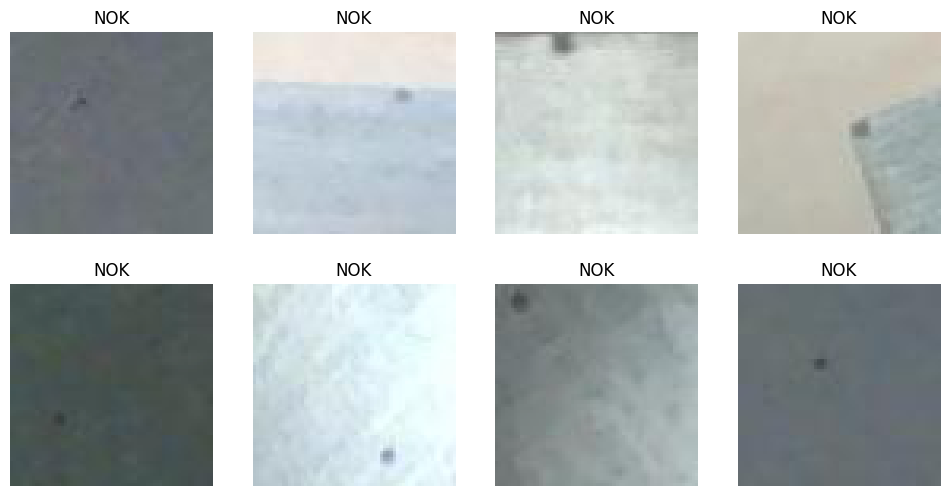

In [9]:
dls.valid.show_batch()

In [10]:
learn = cnn_learner(dls, resnet18, 
                    loss_func=CrossEntropyLossFlat(), 
                    metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd

In [ ]:
learn.lr_find()

In [11]:
learn.fine_tune(100, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.170794,0.909576,0.800000,00:06


epoch,train_loss,valid_loss,accuracy,time
0,1.404289,0.684880,0.800000,00:02
1,1.392393,0.620248,0.700000,00:02
2,1.168469,0.430287,0.850000,00:01
3,1.107883,0.402034,0.800000,00:01
4,1.061901,0.695988,0.700000,00:01
5,1.012878,0.191486,0.900000,00:01
6,0.962353,0.235056,0.900000,00:01
7,0.898032,0.437587,0.850000,00:02
8,0.839382,0.584800,0.850000,00:02
9,0.878387,0.421043,0.850000,00:01


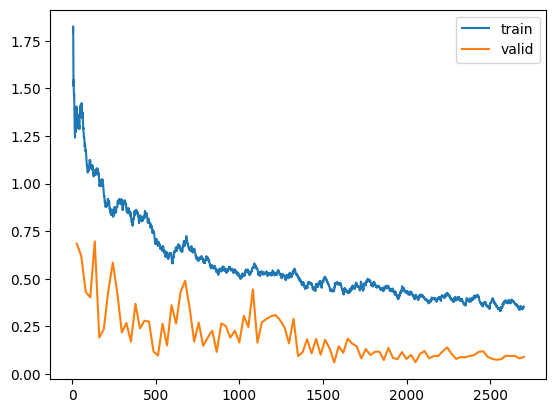

In [12]:
learn.recorder.plot_loss()

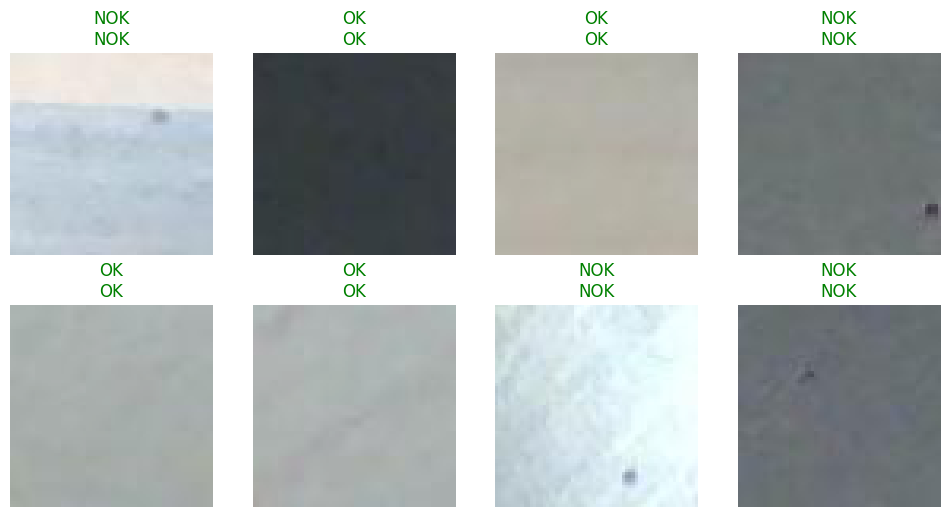

In [13]:
learn.show_results()

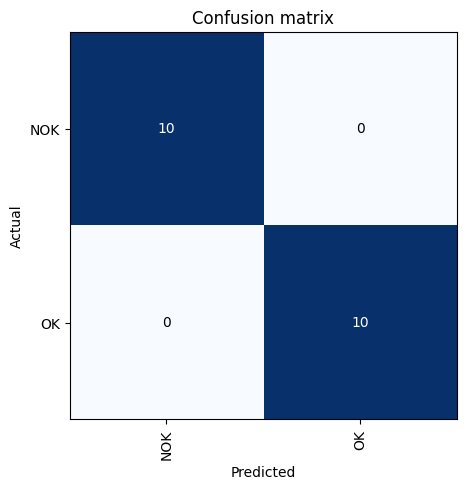

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

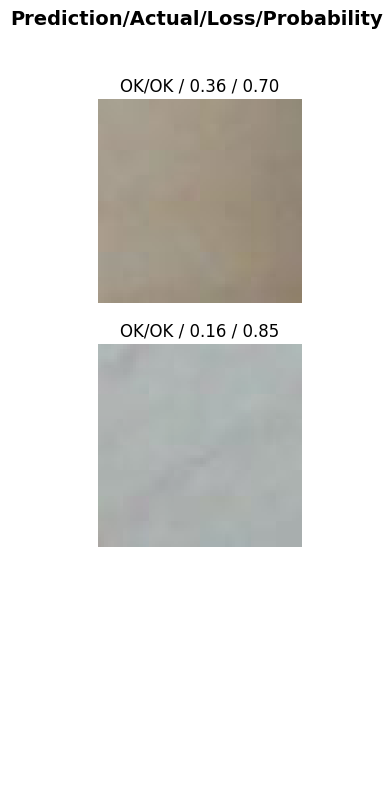

In [15]:
interp.plot_top_losses(2, nrows=3)

In [17]:
from google.colab import files
learn.export('model.pkl')
files.download("model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
!unzip -q Pellicule.zip

In [19]:
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Charger l'image
base = Image.open('/content/inf/WIN_20230524_14_40_57_Pro.jpg')
img1 = ImageDraw.Draw(base) 
img = np.asarray(base)

# Définir la taille des patches
patch_size = 64

# Parcourir les patches de l'image
size = 64
X = int(np.shape(img)[0]/size)
Y = int(np.shape(img)[1]/size)
for i in range(0,X):
  for j in range (0,Y):
    new = img[i*size:(i+1)*size, j*size:(j+1)*size]
    prediction = learn.predict(new) 
    if np.asscalar(prediction[2][0]) >= 0.8:
      shape = [((j+1)*size, (i+1)*size), (j*size, i*size)]
      img1.rectangle(shape, fill=None, outline ="red", width=3)

base.show()

<ipython-input-19-309db6072258>:22: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if np.asscalar(prediction[2][0]) >= 0.8:


KeyboardInterrupt: ignored

In [19]:
!zip -r model.zip models

  adding: models/ (stored 0%)
  adding: models/model.pth (deflated 7%)


In [25]:
from google.colab import files
files.download("./model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>